In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random
from flax import nnx
import optax

import matplotlib
import matplotlib.pyplot as plt

import zarr
import xarray as xr

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

import math

In [2]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = np.moveaxis(data[(lag + horizon):][:,None], 1, 3)
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 3)
    return x_t, y_t

In [3]:
class Block(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.proj = nnx.Conv(dim, dim_out, (3, 3), padding = 'CIRCULAR', rngs = rngs)
        self.norm = nnx.BatchNorm(dim_out, rngs = rngs)

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return nnx.silu(x)

class ResnetBlock(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.block1 = Block(dim, dim_out, rngs = rngs)
        self.block2 = Block(dim_out, dim_out, rngs = rngs)
        self.block3 = Block(dim_out, dim_out, rngs = rngs)
        self.res_conv = nnx.Conv(dim, dim_out, (1, 1), rngs = rngs)

    def __call__(self, x):
        h = self.block1(x)
        h = self.block2(h)
        h = self.block3(h)
        return h + self.res_conv(x)

class ClimateNO(nnx.Module):
    def __init__(self, lag, rngs = nnx.Rngs):
        self.enc = nnx.Conv(lag, 30, (1, 1), rngs = rngs)
        self.res1 = ResnetBlock(30, 32, rngs = rngs)
        self.res2 = ResnetBlock(32, 16, rngs = rngs)
        self.res3 = ResnetBlock(16, 1, rngs = rngs)
        self.dec = nnx.Conv(1, 1, (1, 1), rngs = rngs)

    def __call__(self, x):
        # m = jnp.mean(x, axis = 3)[:,:,:,None]
        h = self.enc(x)
        h = self.res1(h)
        h = self.res2(h)
        h = self.res3(h)
        h = self.dec(h)
        return h

In [4]:
def train_step(model, optimizer, x, y):
  def loss_fn(model):
    quant = 1 - 0.1
    y_pred = model(x)
    y_abs = jnp.abs(y)
    resid = y_abs - y_pred
    loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
    return jnp.mean(loss)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # in-place updates

  return loss

train_step = nnx.jit(train_step)

In [5]:
# dtrain = np.load('./data/era5_train_small.npy', mmap_mode='r+')

In [6]:
np.random.seed(0)
n = 5000
ttrain = np.linspace(0, 2, n)
mu = np.sin(2 * math.pi * ttrain)
sd = np.sqrt(0.5 + np.sin(2 * math.pi * ttrain)**2)
xtrain = mu[:,None,None,None] + np.random.normal(0, 0.1, (n, 20, 20, 1))
ytrain = 2 * xtrain + sd[:,None,None,None] * np.random.normal(0, 1, (n, 20, 20, 1))

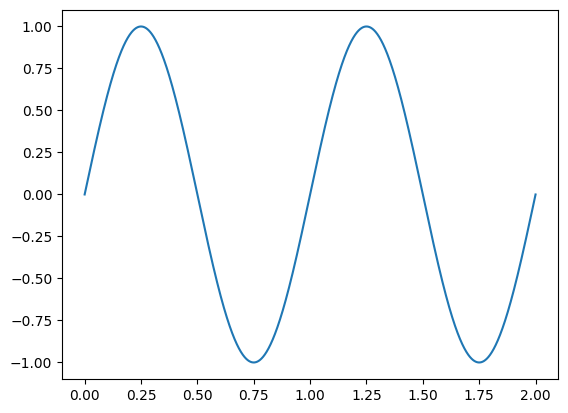

In [7]:
plt.plot(ttrain, mu)

In [8]:
epochs = 100
batch = 50
niter = int(xtrain.shape[0]/batch)
trace = []

model = ClimateNO(1, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for b in trange(epochs):
    rng, perm_rng = random.split(rng, 2)
    xtrain = random.permutation(perm_rng, xtrain)
    ytrain = random.permutation(perm_rng, ytrain)
    
    for i in range(niter):
        xt = xtrain[(i*batch):((i+1)*batch)]
        yt = ytrain[(i*batch):((i+1)*batch)]
    
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)
        print(f'loss: {loss}', end='\r')


  0%|          | 0/100 [00:00<?, ?it/s]

loss: 0.15506359934806824

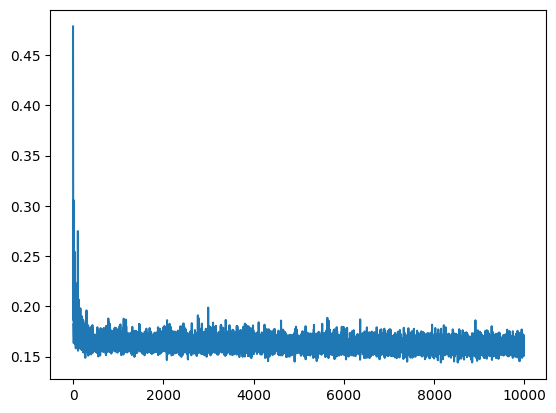

In [9]:
plt.plot(trace[10:])

In [10]:
import os
import orbax.checkpoint as ocp

# extract state
_, state = nnx.split(model)

# save
checkpointer = ocp.StandardCheckpointer()
checkpointer.save(os.getcwd() + '/models/' + 'example1_quant_state', state)